# Analisis de datos

In [2]:
import json
import pandas as pd
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
# Cargar el archivo JSON
with open("pioneer_challenges.json") as f:
    tournaments = json.load(f)

# Mapeo de colores
color_map = ["white", "blue", "black", "red", "green"]

# Función para codificar los colores en una lista binaria
def encode_colors(colors):
    return ['1' if color in colors else '0' for color in color_map]

# Diccionario para almacenar resultados por combinación de colores por fecha
data = []

# Procesar cada torneo
for tournament in tournaments:
    date = tournament["date"]
    color_stats = defaultdict(lambda: {"position_sum": 0, "popularity": 0})

    for position in tournament["positions"]:
        place = int(position["place"].replace("th", "").replace("st", "").replace("nd", "").replace("rd", ""))
        color_encoding = encode_colors(position["colors"])
        
        # Convertir encoding a una tupla para usarla como clave en el diccionario
        color_encoding_tuple = tuple(color_encoding)
        
        # Acumular posición y contar popularidad
        color_stats[color_encoding_tuple]["position_sum"] += place
        color_stats[color_encoding_tuple]["popularity"] += 1

    # Calcular el promedio de posiciones para cada combinación de colores
    for color_encoding, stats in color_stats.items():
        average_position = stats["position_sum"] / stats["popularity"]
        data.append({
            "date": date,
            "color_encoding": ''.join(list(color_encoding)),
            "average_position": average_position,
            "popularity": stats["popularity"]
        })

# Convertir los datos a un DataFrame
df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"])


In [4]:
df

,date,color_encoding,average_position,popularity
0,2024-10-28,11000,13.333333,3
1,2024-10-28,00110,15.000000,10
2,2024-10-28,10100,4.000000,1
3,2024-10-28,11101,15.500000,2
4,2024-10-28,01010,18.375000,8
...,...,...,...,...
8454,2021-01-02,11001,14.000000,1
8455,2021-01-02,00001,15.000000,1
8456,2021-01-02,11011,19.000000,2
8457,2021-01-02,11010,24.000000,2


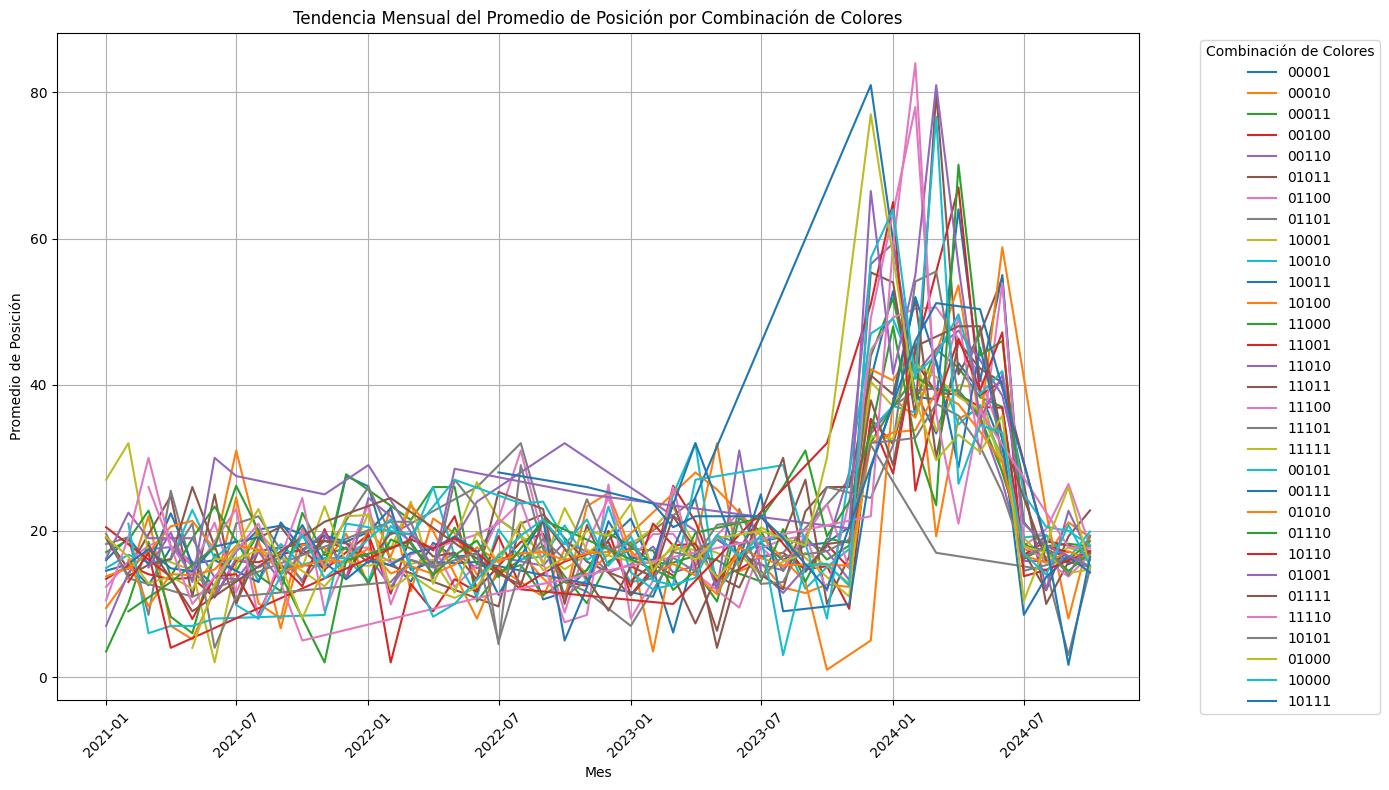

In [ ]:
df['date'] = pd.to_datetime(df['date'])

df['month'] = df['date'].dt.to_period('M')

monthly_trend = df.groupby(['month', 'color_encoding']).agg({
    'average_position': 'mean'
}).reset_index()

monthly_trend['month'] = monthly_trend['month'].dt.to_timestamp()

plt.figure(figsize=(14, 8))
for color_combination in monthly_trend['color_encoding'].unique():
    subset = monthly_trend[monthly_trend['color_encoding'] == color_combination]
    plt.plot(subset['month'], subset['average_position'], label=str(color_combination))

plt.title('Tendencia Mensual del Promedio de Posición por Combinación de Colores')
plt.xlabel('Mes')
plt.ylabel('Promedio de Posición')
plt.legend(title="Combinación de Colores", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

31


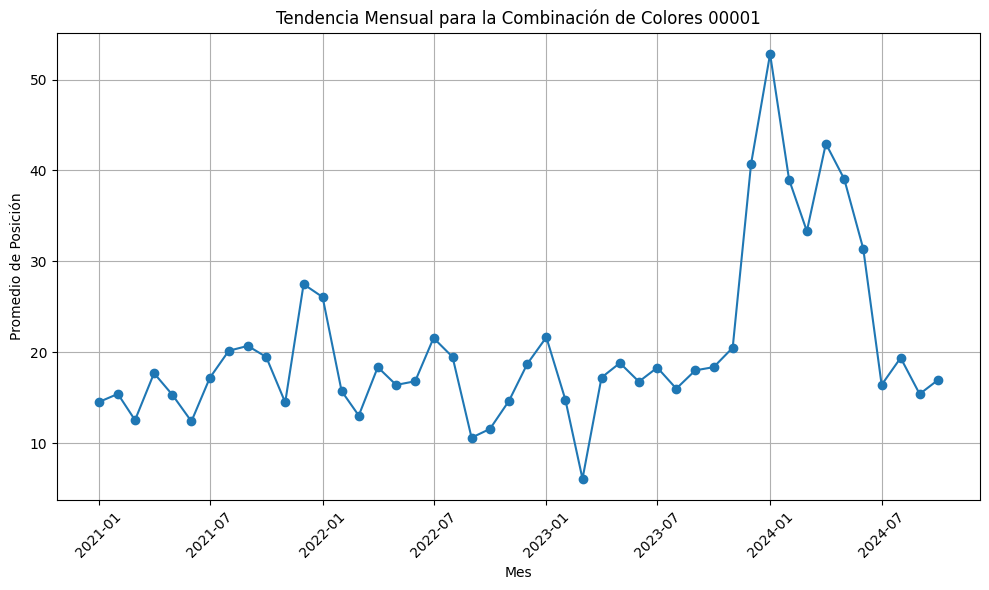

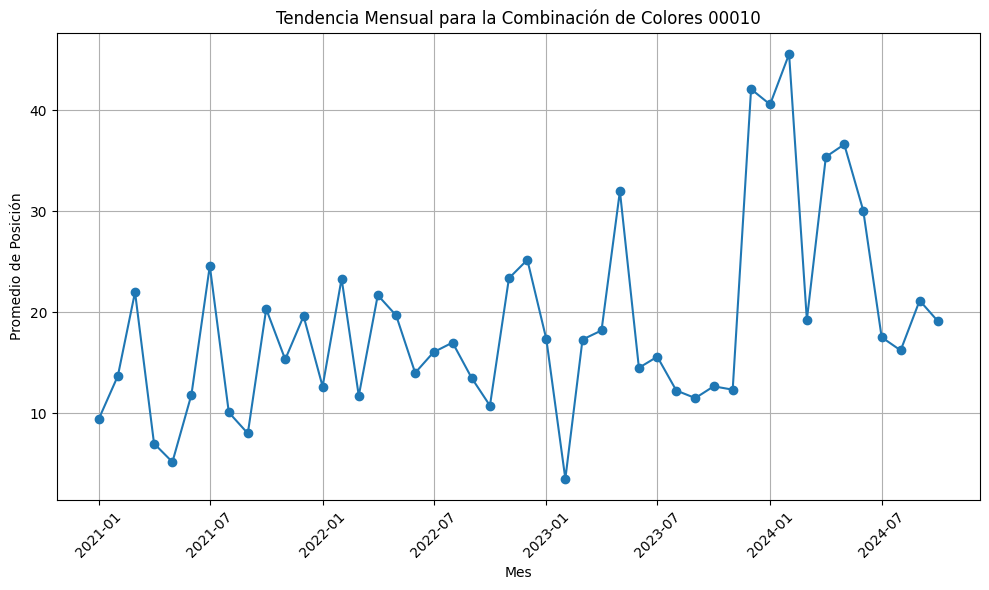

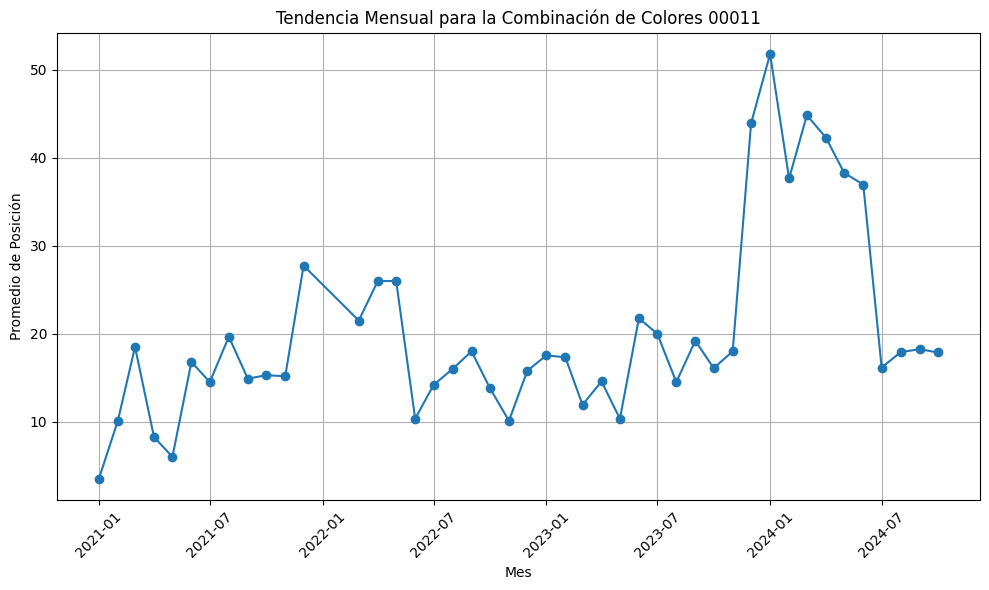

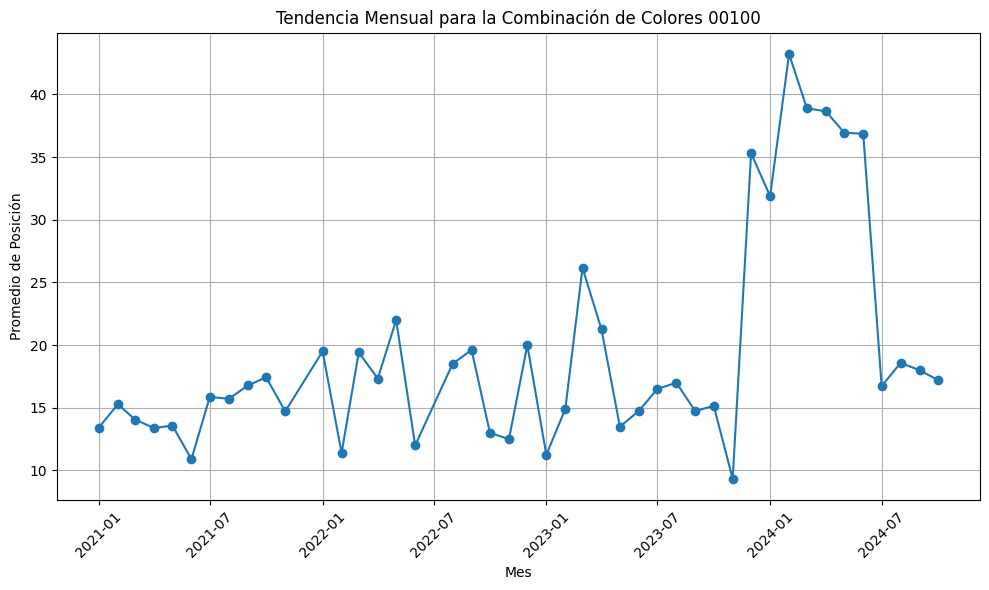

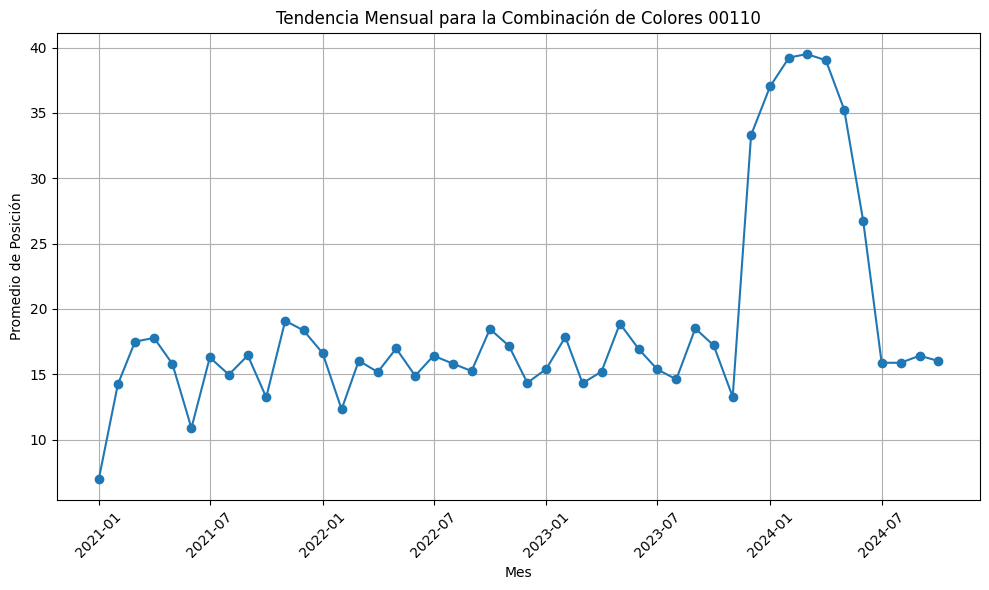

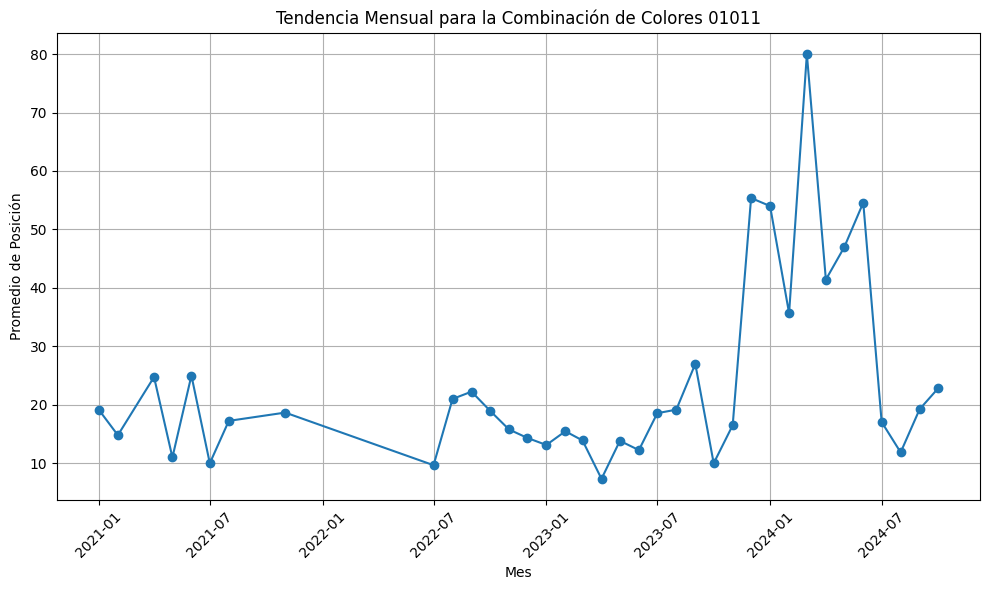

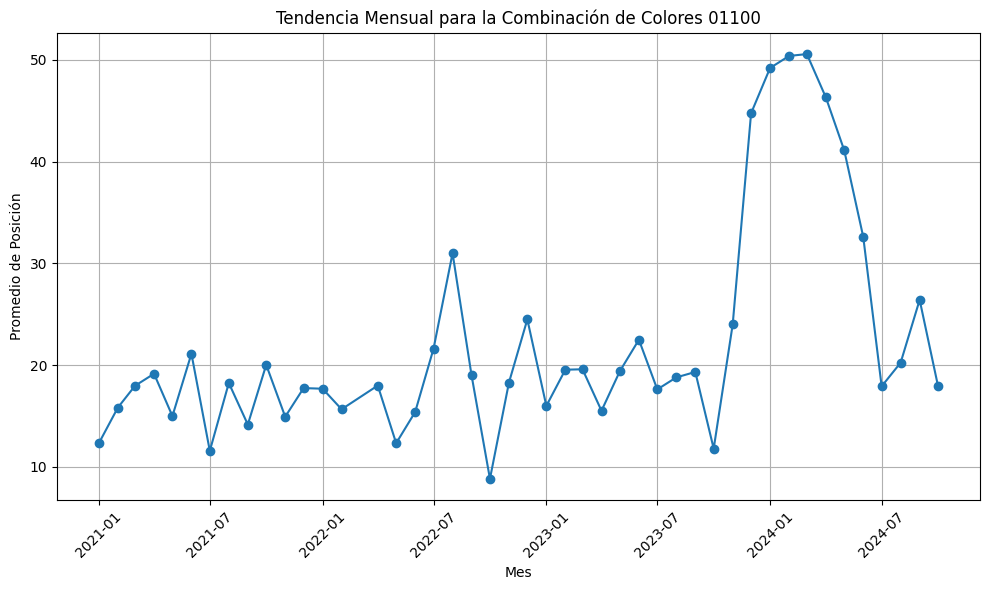

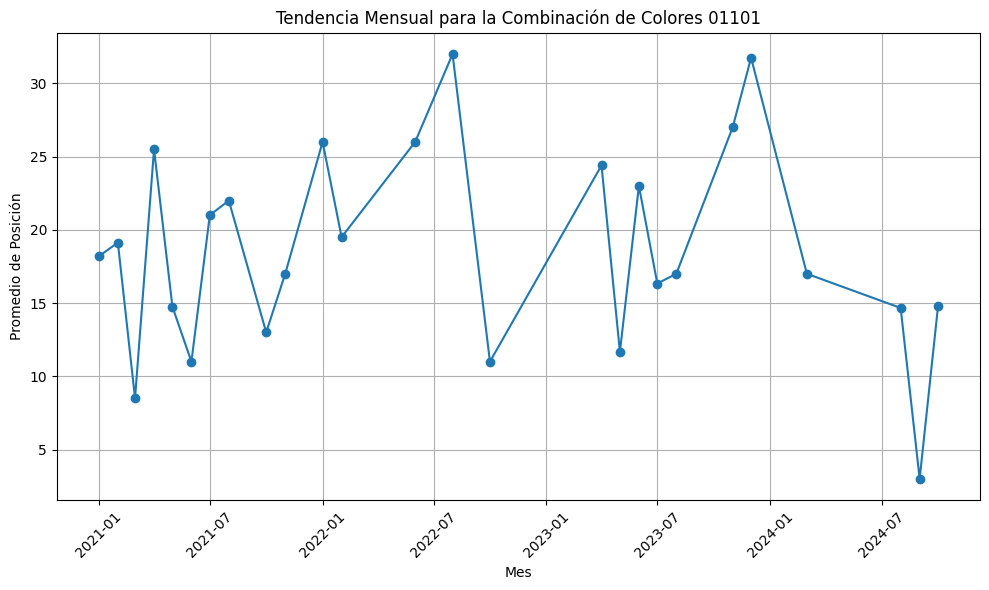

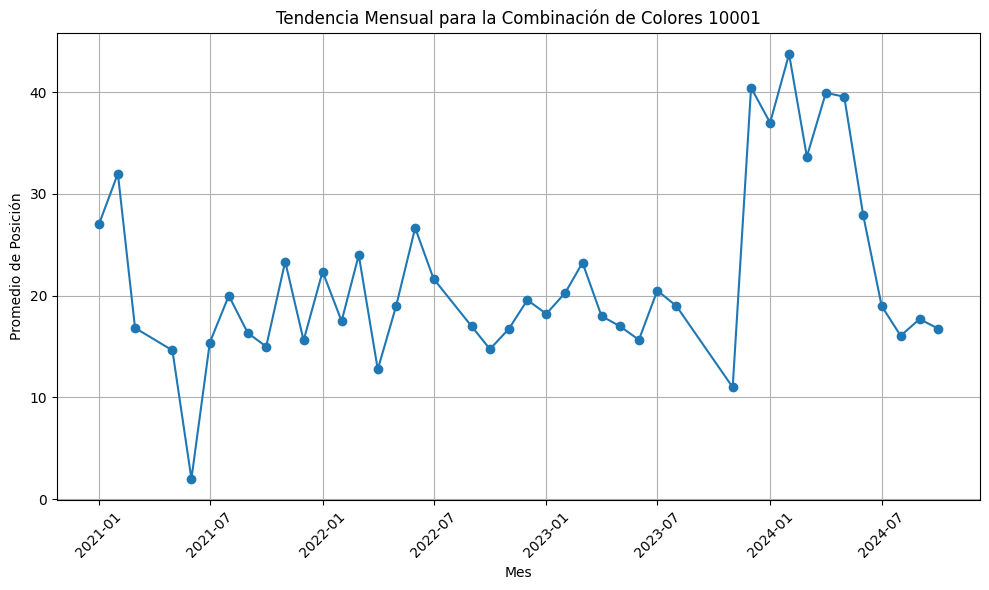

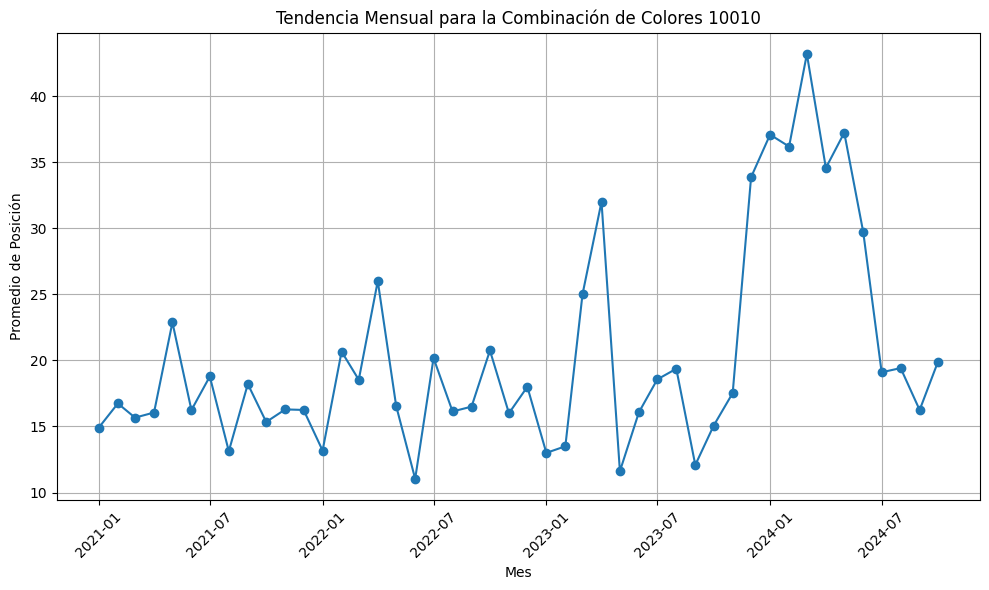

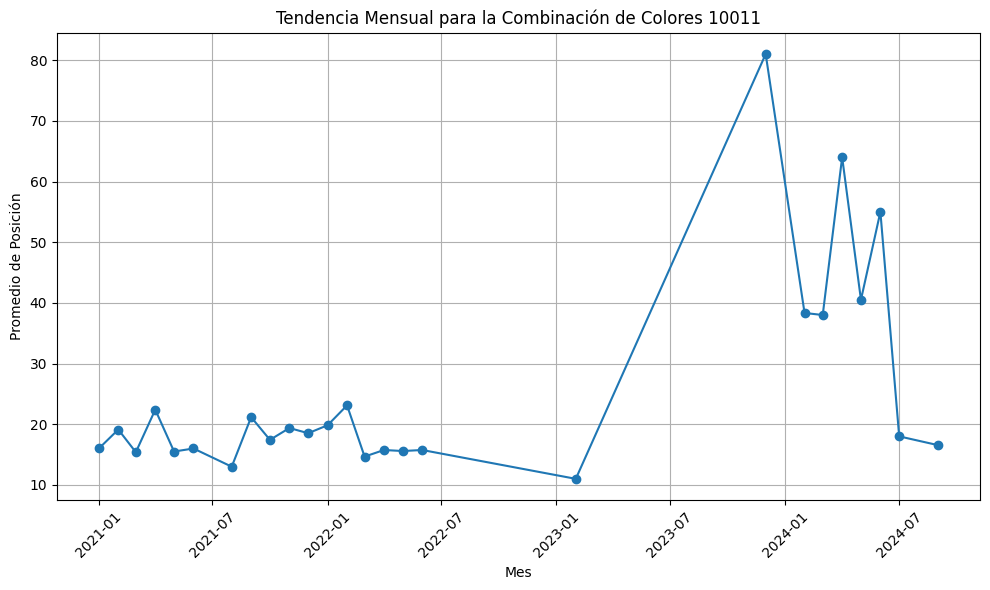

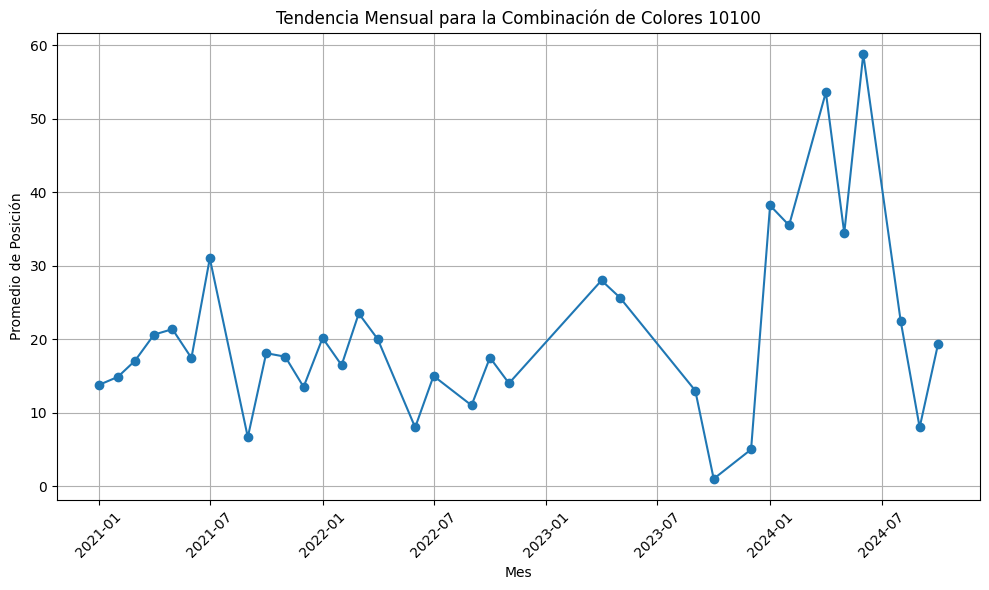

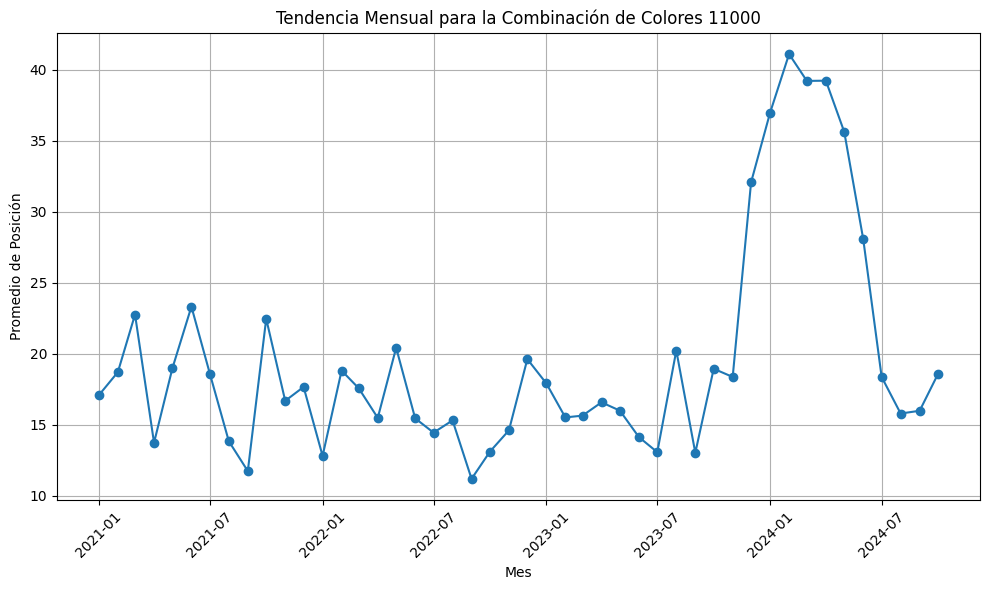

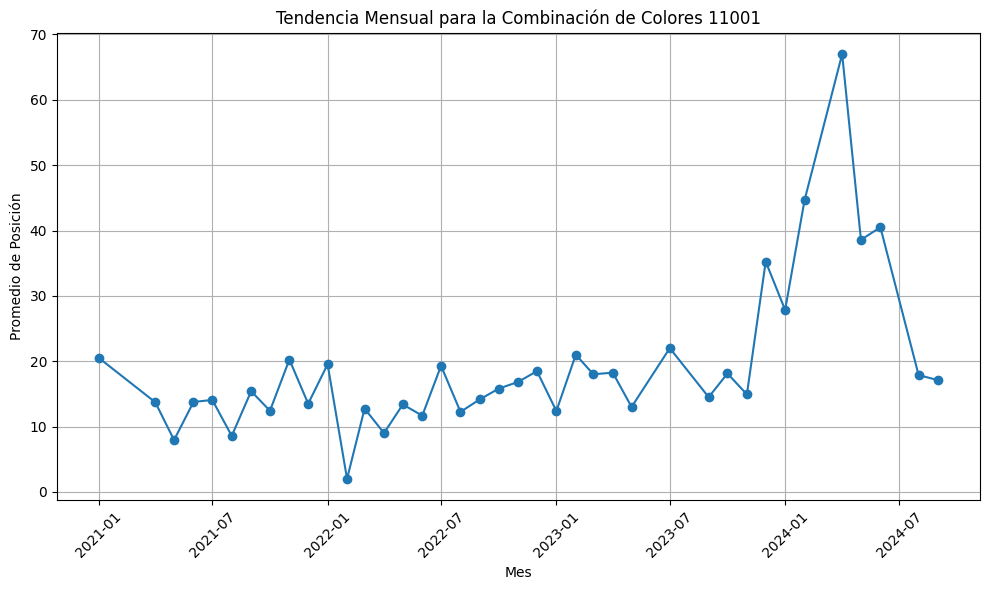

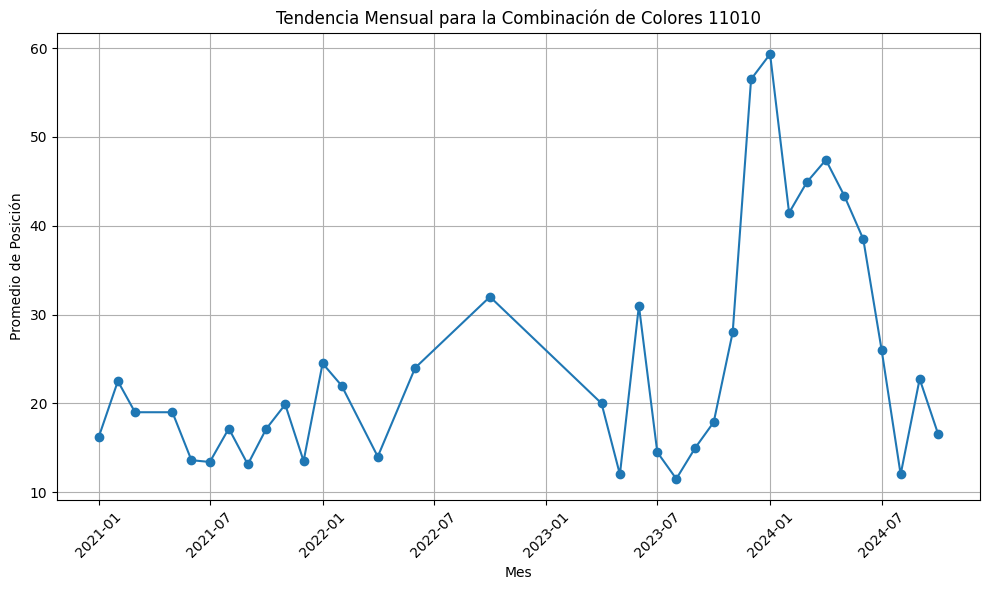

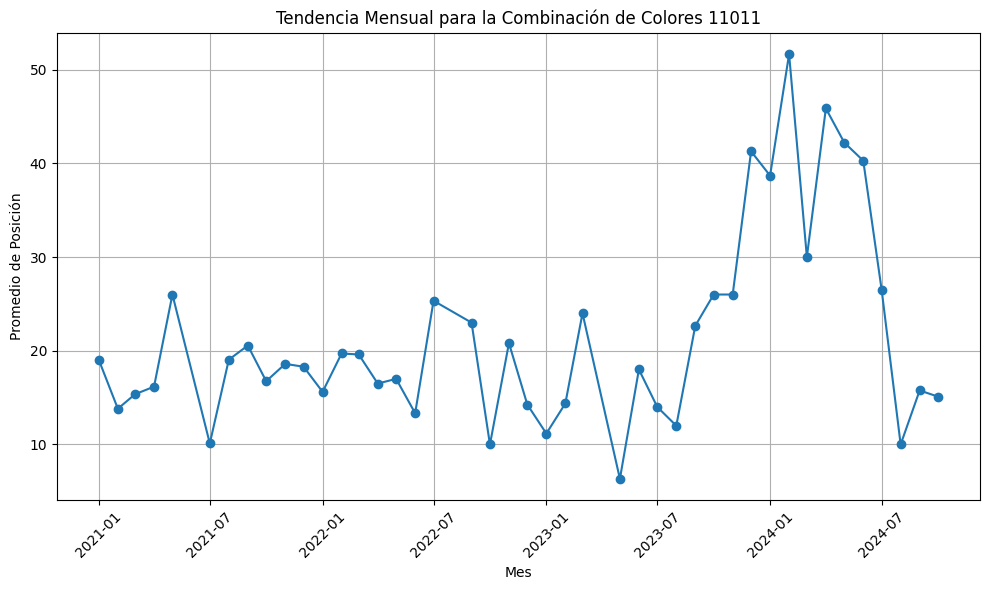

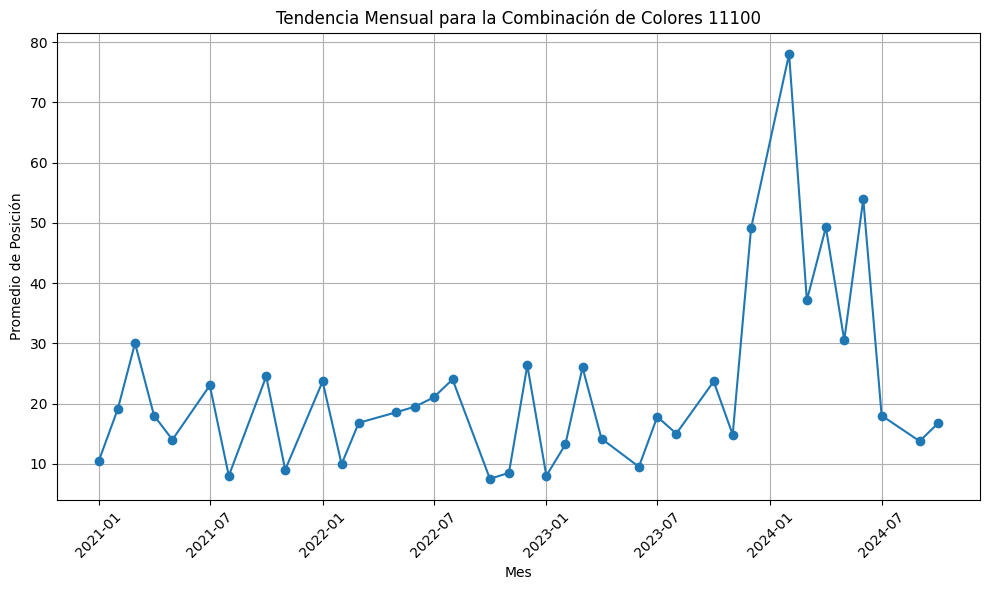

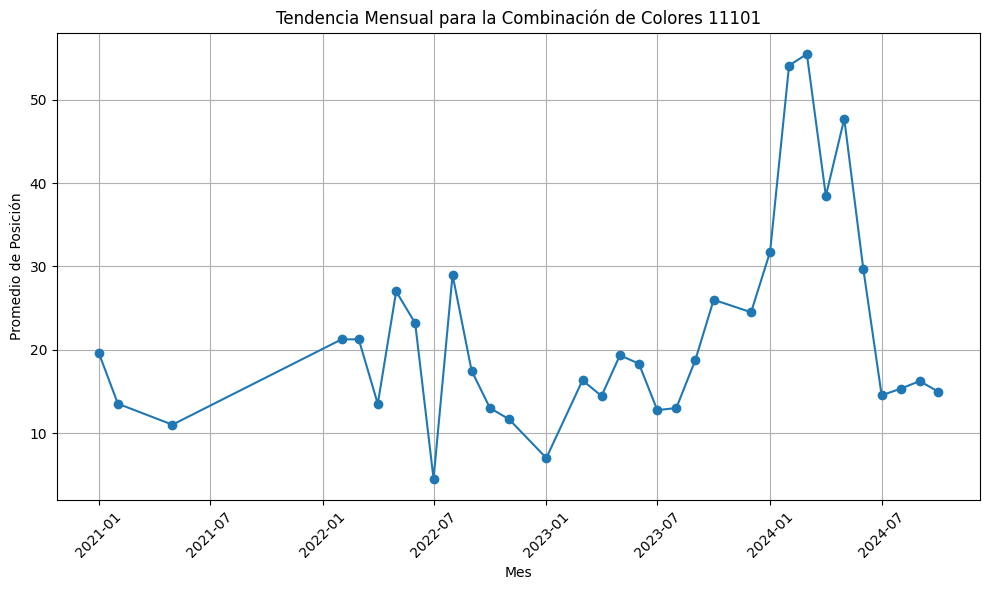

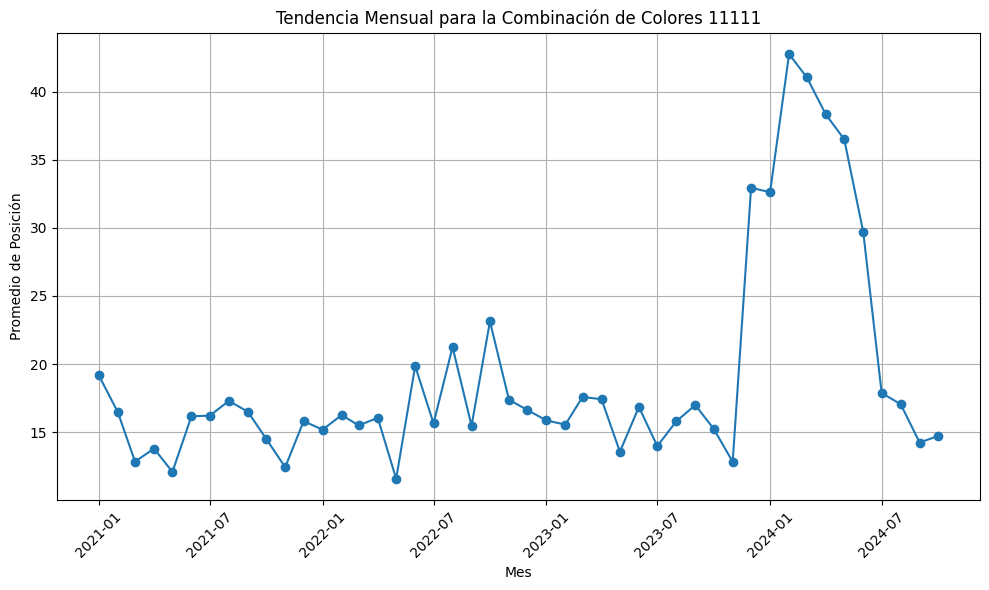

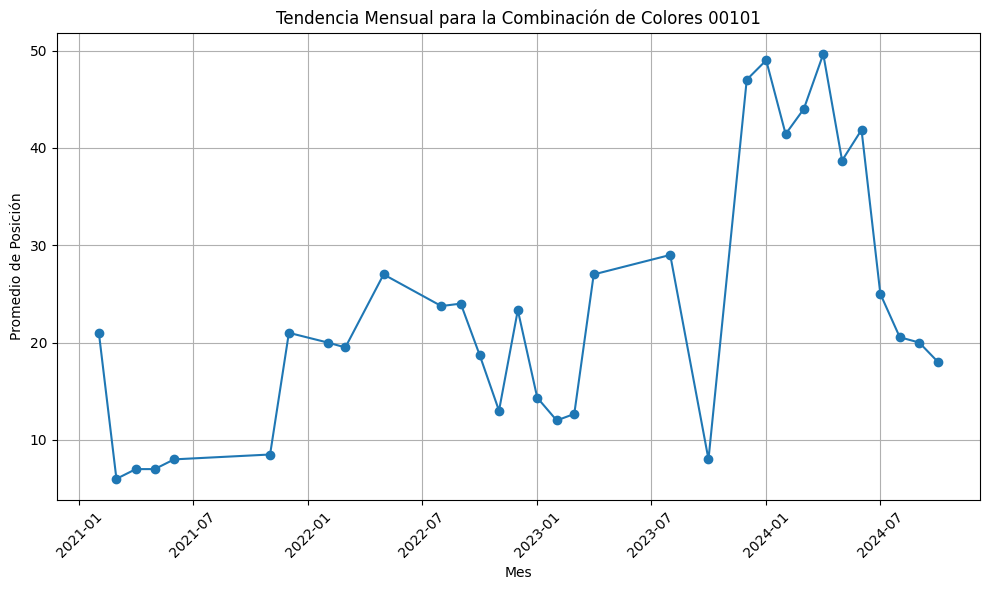

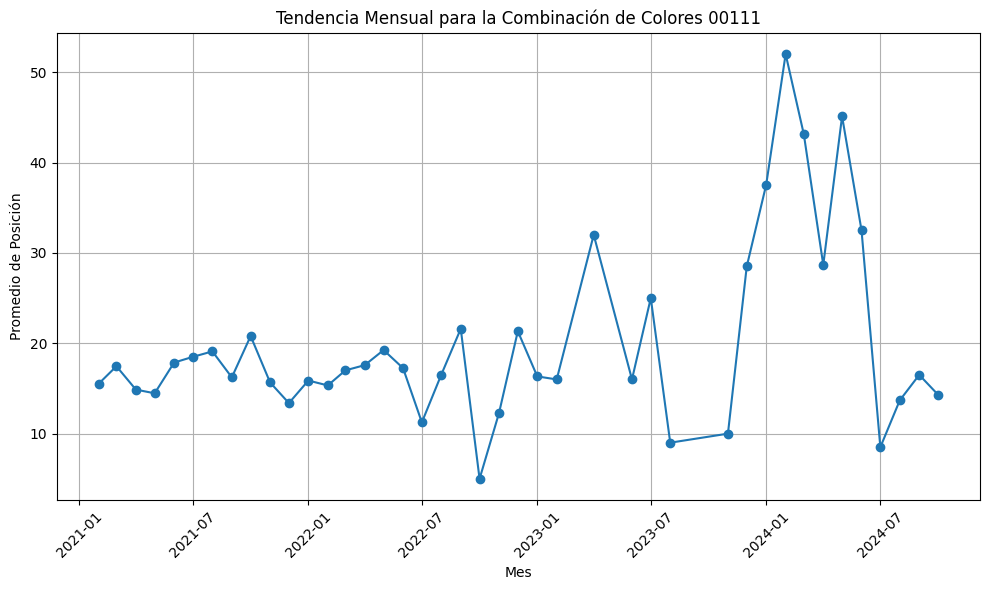

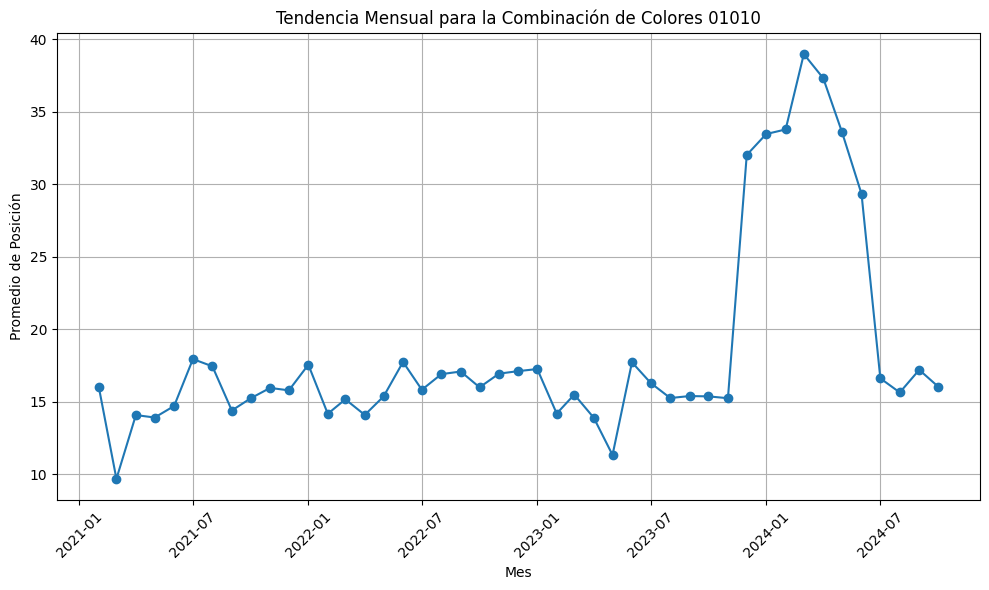

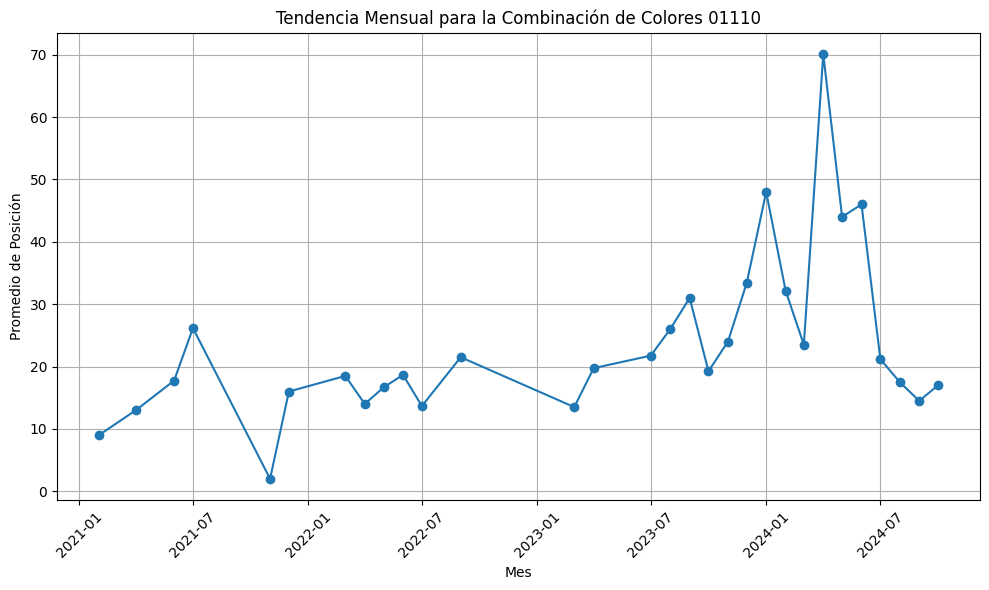

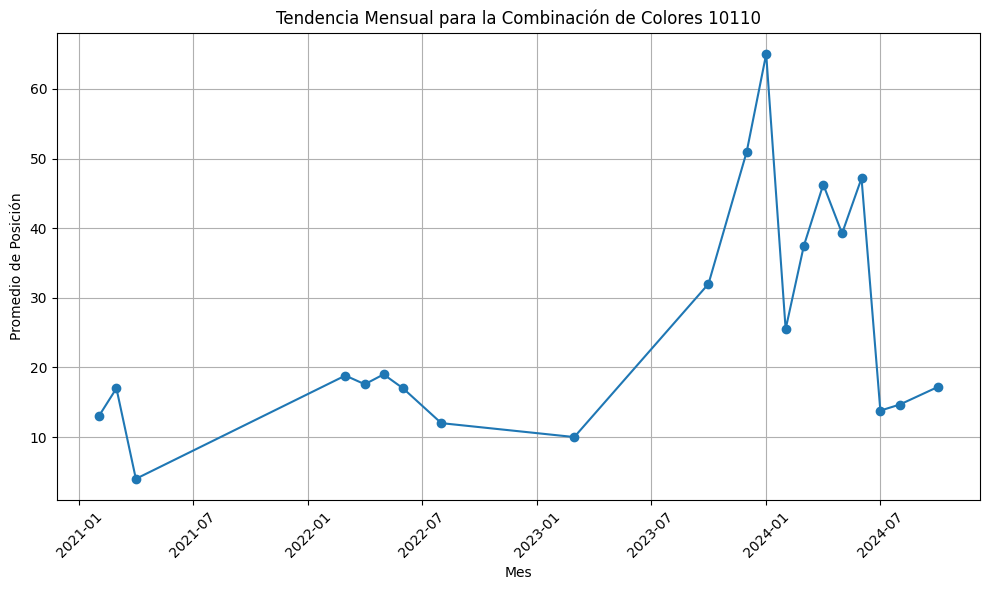

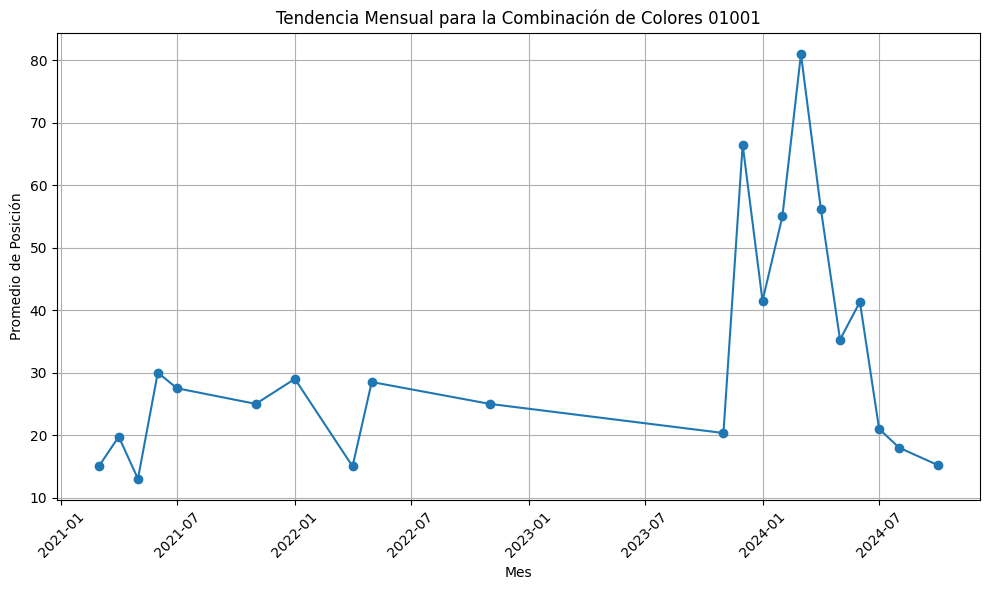

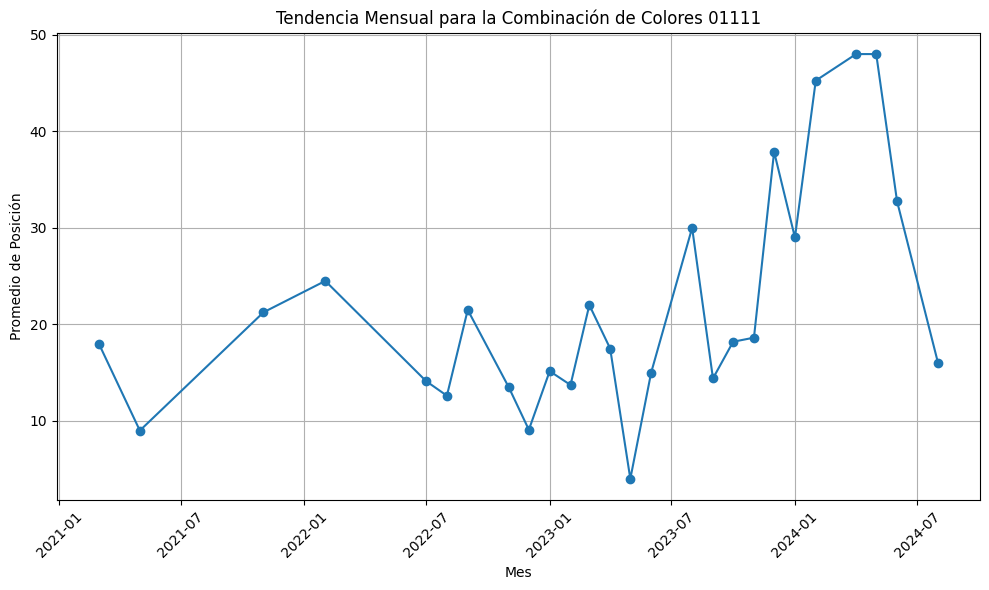

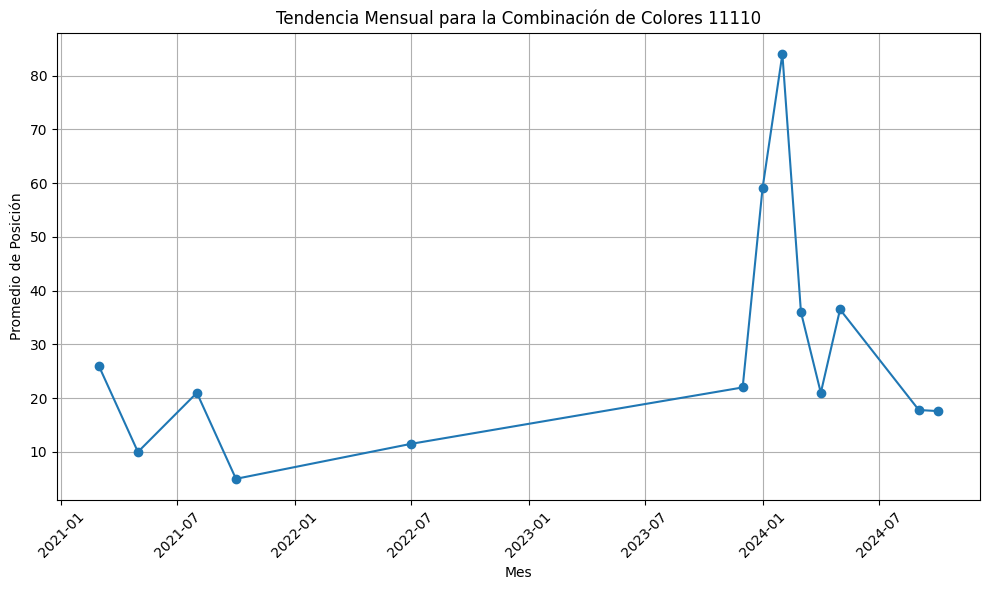

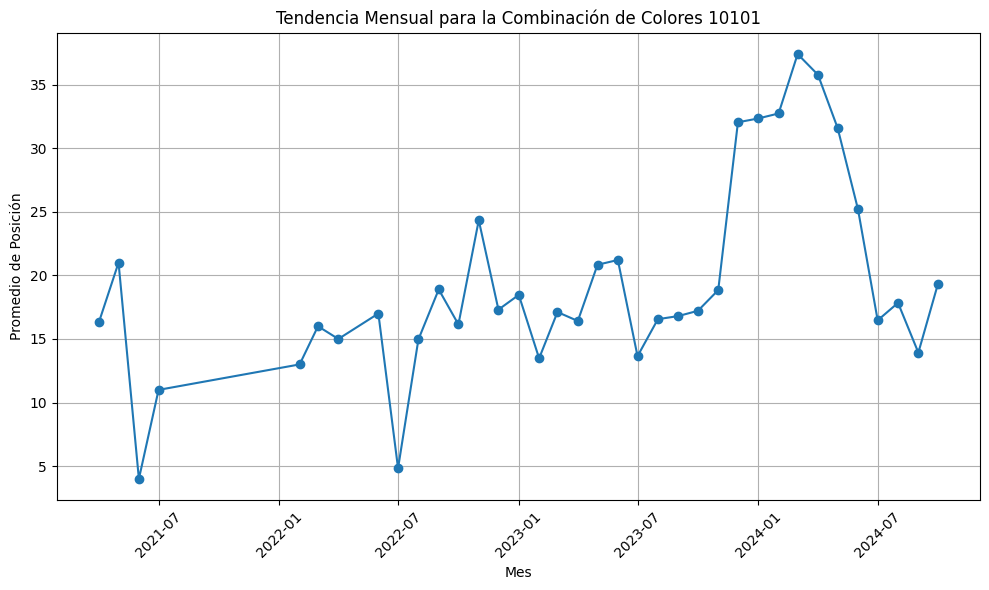

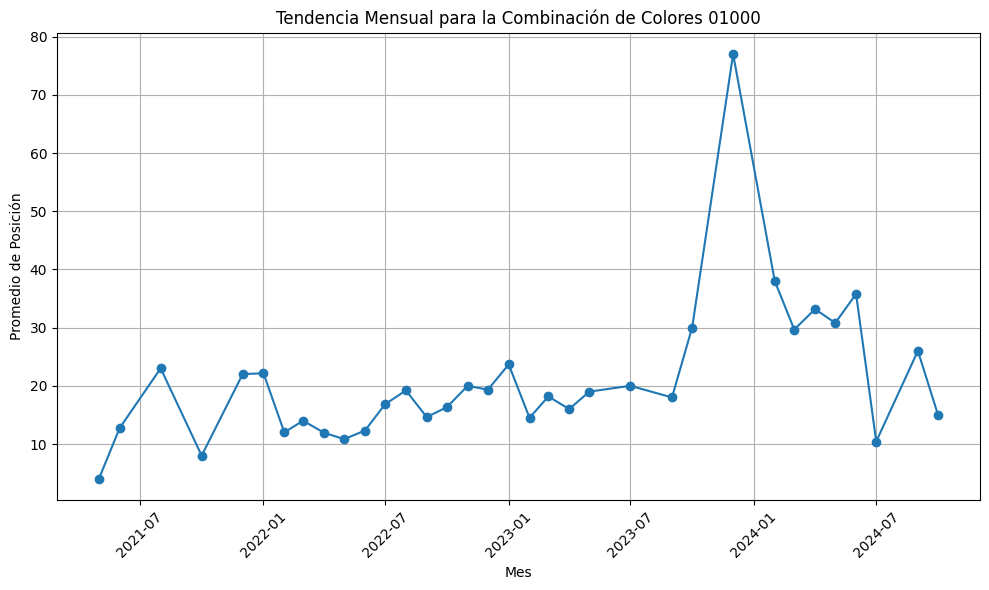

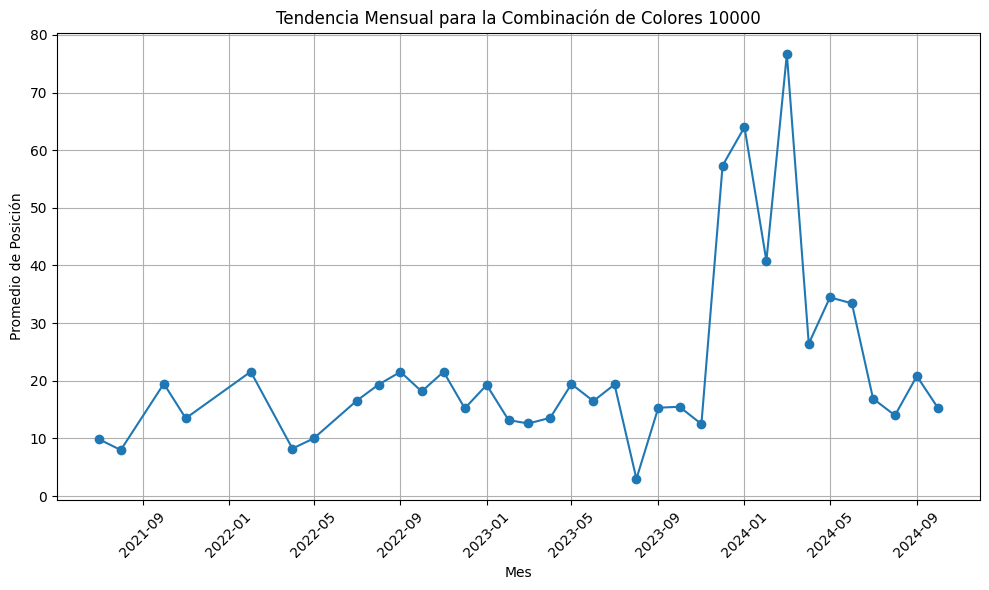

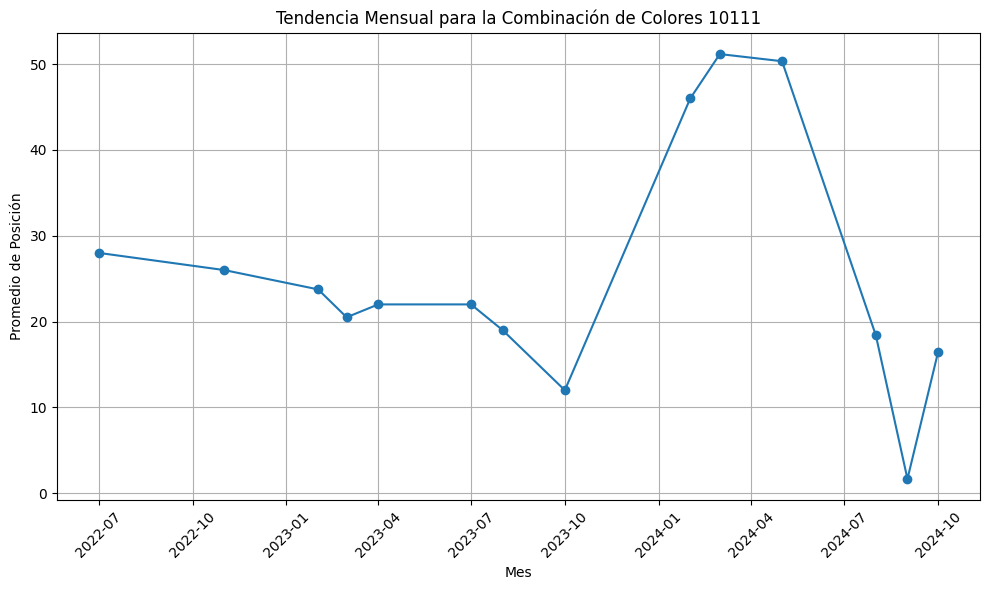

In [6]:
unique_color_encodings = monthly_trend['color_encoding'].unique()
print(len(unique_color_encodings))
for color_combination in unique_color_encodings:
    subset = monthly_trend[monthly_trend['color_encoding'] == color_combination]
    
    # Crear un nuevo gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(subset['month'], subset['average_position'], marker='o', linestyle='-')
    
    # Configuración del gráfico
    plt.title(f'Tendencia Mensual para la Combinación de Colores {color_combination}')
    plt.xlabel('Mes')
    plt.ylabel('Promedio de Posición')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

In [7]:
df.head(10)

,date,color_encoding,average_position,popularity,month
0,2024-10-28,11000,13.333333,3,2024-10
1,2024-10-28,00110,15.000000,10,2024-10
2,2024-10-28,10100,4.000000,1,2024-10
3,2024-10-28,11101,15.500000,2,2024-10
4,2024-10-28,01010,18.375000,8,2024-10
5,2024-10-28,10001,16.000000,2,2024-10
6,2024-10-28,11111,12.000000,1,2024-10
7,2024-10-28,01110,13.000000,1,2024-10
8,2024-10-28,10110,18.500000,2,2024-10
9,2024-10-28,00011,30.000000,1,2024-10


In [8]:
df.tail(10)

,date,color_encoding,average_position,popularity,month
8449,2021-01-02,11100,15.500000,2,2021-01
8450,2021-01-02,01101,20.500000,4,2021-01
8451,2021-01-02,01011,18.333333,3,2021-01
8452,2021-01-02,10100,19.000000,5,2021-01
8453,2021-01-02,00100,21.666667,3,2021-01
8454,2021-01-02,11001,14.000000,1,2021-01
8455,2021-01-02,00001,15.000000,1,2021-01
8456,2021-01-02,11011,19.000000,2,2021-01
8457,2021-01-02,11010,24.000000,2,2021-01
8458,2021-01-02,11101,23.000000,1,2021-01


# Normalizacion y preparacion

In [9]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

## Agrupacion por mes

In [10]:
monthly_df = df.groupby(['month', 'color_encoding']).apply(
    lambda x: pd.Series({
        'average_position_monthly': np.sum(x['average_position'] * x['popularity']) / np.sum(x['popularity']),
        'popularity_monthly': np.mean(x['popularity'])  # Promedio de popularidad mensual
    })
).reset_index()

C:\Users\PiCi\AppData\Local\Temp\ipykernel_12392\1024490440.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_df = df.groupby(['month', 'color_encoding']).apply(


In [11]:
monthly_df.head(10)

,month,color_encoding,average_position_monthly,popularity_monthly
0,2021-01,00001,15.213115,4.066667
1,2021-01,00010,8.857143,1.909091
2,2021-01,00011,4.000000,1.500000
3,2021-01,00100,13.157895,2.533333
4,2021-01,00110,7.000000,1.000000
5,2021-01,01011,17.580645,2.384615
6,2021-01,01100,12.333333,1.000000
7,2021-01,01101,17.977778,3.214286
8,2021-01,10001,27.000000,1.000000
9,2021-01,10010,16.224490,3.266667


## Rellenado de datos

In [12]:
all_months = monthly_df['month'].unique()
all_color_encodings = monthly_df['color_encoding'].unique()
all_combinations = pd.MultiIndex.from_product([all_months, all_color_encodings], names=['month', 'color_encoding']).to_frame(index=False)

all_combinations.head()

,month,color_encoding
0,2021-01,00001
1,2021-01,00010
2,2021-01,00011
3,2021-01,00100
4,2021-01,00110


In [13]:
monthly_df_complete = all_combinations.merge(monthly_df, on=['month', 'color_encoding'], how='left')
monthly_df_complete['average_position_monthly'].fillna(0, inplace=True)
monthly_df_complete['popularity_monthly'].fillna(0, inplace=True)

C:\Users\PiCi\AppData\Local\Temp\ipykernel_12392\1298626636.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  monthly_df_complete['average_position_monthly'].fillna(0, inplace=True)
C:\Users\PiCi\AppData\Local\Temp\ipykernel_12392\1298626636.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

In [14]:
monthly_df_complete.head(20)

,month,color_encoding,average_position_monthly,popularity_monthly
0,2021-01,00001,15.213115,4.066667
1,2021-01,00010,8.857143,1.909091
2,2021-01,00011,4.000000,1.500000
3,2021-01,00100,13.157895,2.533333
4,2021-01,00110,7.000000,1.000000
5,2021-01,01011,17.580645,2.384615
6,2021-01,01100,12.333333,1.000000
7,2021-01,01101,17.977778,3.214286
8,2021-01,10001,27.000000,1.000000
9,2021-01,10010,16.224490,3.266667


## Normalizacion

In [15]:
scaler_avg_pos = MinMaxScaler()
scaler_popularity = MinMaxScaler()
monthly_df_complete['average_position_monthly_norm'] = scaler_avg_pos.fit_transform(monthly_df_complete[['average_position_monthly']])
monthly_df_complete['popularity_monthly_norm'] = np.log1p(monthly_df_complete['popularity_monthly'])
monthly_df_complete['color_encoding_norm'] = monthly_df_complete['color_encoding'].apply(lambda x: int(x, 2) / 31) 

In [16]:
monthly_df_complete.head(20)

,month,color_encoding,average_position_monthly,popularity_monthly,average_position_monthly_norm,popularity_monthly_norm,color_encoding_norm
0,2021-01,00001,15.213115,4.066667,0.181109,1.622683,0.032258
1,2021-01,00010,8.857143,1.909091,0.105442,1.067841,0.064516
2,2021-01,00011,4.000000,1.500000,0.047619,0.916291,0.096774
3,2021-01,00100,13.157895,2.533333,0.156642,1.262242,0.129032
4,2021-01,00110,7.000000,1.000000,0.083333,0.693147,0.193548
5,2021-01,01011,17.580645,2.384615,0.209293,1.219240,0.354839
6,2021-01,01100,12.333333,1.000000,0.146825,0.693147,0.387097
7,2021-01,01101,17.977778,3.214286,0.214021,1.438480,0.419355
8,2021-01,10001,27.000000,1.000000,0.321429,0.693147,0.548387
9,2021-01,10010,16.224490,3.266667,0.193149,1.450833,0.580645


## Preparacion de secuencias

In [17]:
sequence_length = 6
features = ['color_encoding_norm', 'average_position_monthly_norm', 'popularity_monthly_norm']
target = 'average_position_monthly_norm'

In [18]:
data_gen = TimeseriesGenerator(
    monthly_df_complete[features].values, monthly_df_complete[target].values,
    length=sequence_length, batch_size=1
)

In [19]:
print(data_gen.data)

[[0.03225806 0.18110851 1.62268314]
 [0.06451613 0.10544218 1.06784063]
 [0.09677419 0.04761905 0.91629073]
 ...
 [0.25806452 0.17857143 0.69314718]
 [0.51612903 0.18181818 0.69314718]
 [0.74193548 0.19557823 0.69314718]]


# Modelo

In [20]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(features))))
model.add(Dense(1))  
model.compile(optimizer='adam', loss='mse')

c:\Users\PiCi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
history = model.fit(data_gen, epochs=50)


Epoch 1/50
 143/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0495

c:\Users\PiCi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0262
Epoch 2/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0151
Epoch 3/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0167
Epoch 4/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0181
Epoch 5/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0146
Epoch 6/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0146
Epoch 7/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0152
Epoch 8/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0136
Epoch 9/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0130
Epoch 10/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0146
Epoch 11/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0137
Epoch 12/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0137
Epoch 13/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0121
Epoch 14/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0125
Epoch 15/50
1420/1420 ━━━━━━━━━━━━━━━━━━

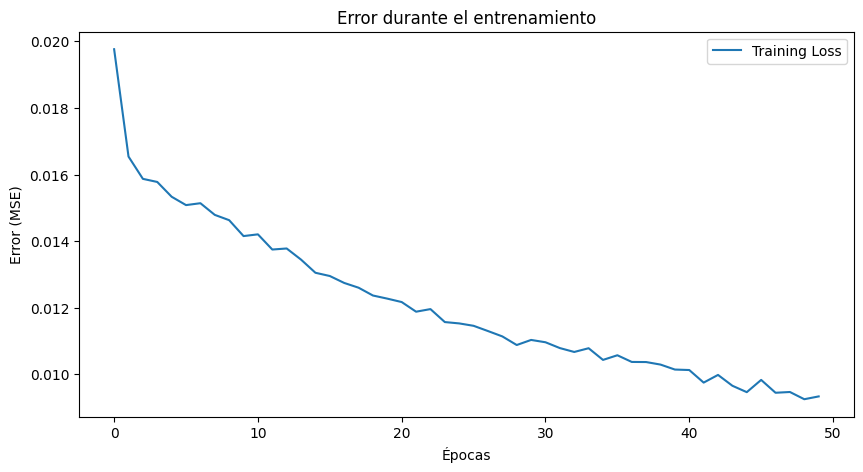

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Error durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Error (MSE)')
plt.legend()
plt.show()

In [23]:
predictions = model.predict(data_gen)

1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step


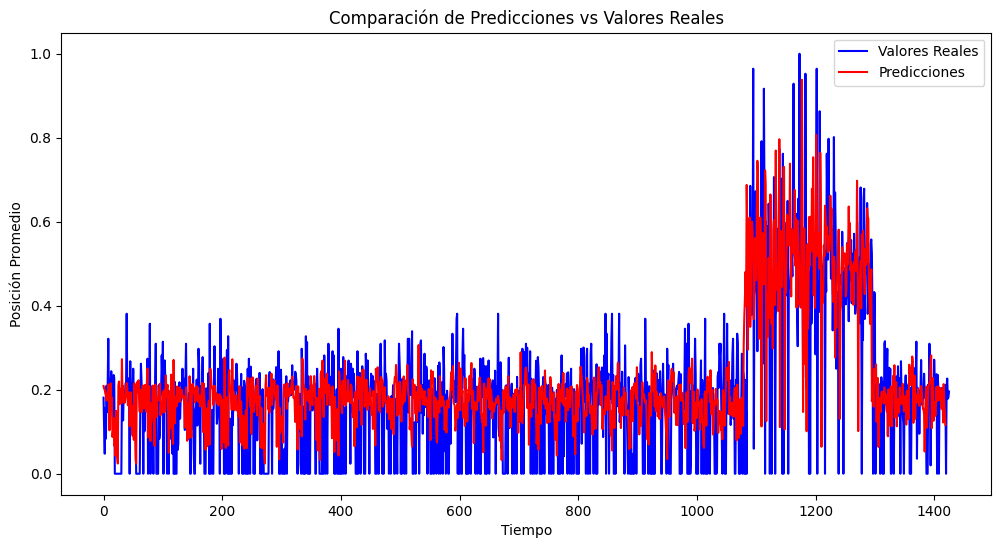

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_df_complete['average_position_monthly_norm'], label='Valores Reales', color='blue')
plt.plot(predictions, label='Predicciones', color='red')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.xlabel('Tiempo')
plt.ylabel('Posición Promedio')
plt.legend()
plt.show()

# Prediccion

In [63]:
max_popularity = 20
max_position = 30

color_comb = ['1','1','1','0','1']
popularity_values = [1,5,10,15,20]

In [67]:
def predict(color_comb, popularity_values, max_popularity, max_position):
    color_encoding_norm = int(''.join(color_comb),2)/31
    sequence_length = 6  

    popularity_values_normalized = (np.array(popularity_values) - 1) / (max_popularity - 1)

    input_sequences = []
    for popularity in popularity_values_normalized:
        sequence = [[color_encoding_norm, 0, popularity]] * sequence_length
        input_sequences.append(sequence)

    input_sequences = np.array(input_sequences)
    
    predictions = model.predict(input_sequences)

    predictions_denormalized = predictions * (max_position - 1) + 1
    
    return predictions_denormalized

In [68]:
predictions_denormalized = predict(color_comb=color_comb, popularity_values=popularity_values, max_popularity=max_popularity, max_position=max_position)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [72]:
for pop, pred in zip(popularity_values, predictions_denormalized):
    print(f"Popularidad: {pop}, Predicción de posición promedio: {pred[0]:.2f}")

Popularidad: 1, Predicción de posición promedio: 6.75
Popularidad: 5, Predicción de posición promedio: 8.37
Popularidad: 10, Predicción de posición promedio: 6.87
Popularidad: 15, Predicción de posición promedio: 5.88
Popularidad: 20, Predicción de posición promedio: 5.51
